In [38]:
# Install required libraries
!pip install --quiet torch torchaudio soundfile librosa transformers nltk
!apt-get install -y espeak-ng
!apt-get update -qq && apt-get install -y -qq espeak-ng
!pip install -q transformers torchaudio librosa phonemizer sentencepiece

import nltk
nltk.download("cmudict")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
espeak-ng is already the newest version (1.50+dfsg-10ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 97 not upgraded.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


True

Objective 1

1. Load and Preprocess the Recorded Speech Signal

In [61]:
import librosa
import torch
from IPython.display import Audio, display

# Load audio (LJ Speech sample or local file)
audio_path = "objective01_n.wav" # Replace with your file
waveform_np, sample_rate = librosa.load(audio_path, sr=None, mono=True)

# Resample to 16kHz as required for Wav2Vec2
target_sr = 16000
waveform_np = librosa.resample(waveform_np, orig_sr=sample_rate, target_sr=target_sr)
waveform = torch.tensor(waveform_np)

print(f"Audio loaded. Sample rate: {target_sr}, Shape: {waveform.shape}")
display(Audio(data=waveform_np, rate=target_sr))

Audio loaded. Sample rate: 16000, Shape: torch.Size([94366])


2 Automatically segment the speech into phoneme-level units (similar to previous lab)

In [40]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch

# Load the direct phoneme recognition model used in Lab 2
model_id = "facebook/wav2vec2-lv-60-espeak-cv-ft"
processor = Wav2Vec2Processor.from_pretrained(model_id)
model = Wav2Vec2ForCTC.from_pretrained(model_id)

# Speech to Phonemes
inputs = processor(waveform_np, sampling_rate=target_sr, return_tensors="pt", padding=True)
with torch.no_grad():
    logits = model(inputs.input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)

# Decode the output
transcription = processor.batch_decode(predicted_ids)[0]
print(f"Recognized Phonemes: {transcription}")

Loading weights:   0%|          | 0/424 [00:00<?, ?it/s]

Recognized Phonemes: ʃ iː dʒ ʌ dʒ d ð ə b l uː p ɛ n p ʊ ɾ ɪ ɾ ɔ n ð ə t eɪ b əl æ n d k w aɪ ə t l i w ɪ s p ɚ d j ɛ s


In [43]:
# Dictionary mapping IPA to ARPAbet
ipa_to_arpa = {
    'iː': 'IY', 'ɪ': 'IH', 'ɛ': 'EH', 'e': 'EH', 'æ': 'AE', 'ɑː': 'AA', 'ɑ': 'AA',
    'ɔː': 'AO', 'ɔ': 'AO', 'ɒ': 'AO', 'ʊ': 'UH', 'uː': 'UW', 'ʌ': 'AH', 'ə': 'AH',
    'ɚ': 'ER', 'ɜː': 'ER', 'aɪ': 'AY', 'aʊ': 'AW', 'oʊ': 'OW', 'o': 'OW', 'ɔɪ': 'OY',
    'eɪ': 'EY', 'p': 'P', 'b': 'B', 't': 'T', 'd': 'D', 'k': 'K', 'ɡ': 'G', 'g': 'G',
    'm': 'M', 'n': 'N', 'ŋ': 'NG', 'f': 'F', 'v': 'V', 'θ': 'TH', 'ð': 'DH', 's': 'S',
    'z': 'Z', 'ʃ': 'SH', 'ʒ': 'ZH', 'h': 'HH', 'tʃ': 'CH', 'dʒ': 'JH', 'l': 'L',
    'ɹ': 'R', 'r': 'R', 'j': 'Y', 'w': 'W', 'ɾ': 'DX'
}

# Dictionary mapping ARPAbet to Voicing and your specific Phoneme Types
arpa_traits = {
    # Vowels (Monophthongs)
    'IY': ('Voiced', 'Vowel'), 'IH': ('Voiced', 'Vowel'), 'EH': ('Voiced', 'Vowel'),
    'AE': ('Voiced', 'Vowel'), 'AA': ('Voiced', 'Vowel'), 'AO': ('Voiced', 'Vowel'),
    'UH': ('Voiced', 'Vowel'), 'UW': ('Voiced', 'Vowel'), 'AH': ('Voiced', 'Vowel'),
    'ER': ('Voiced', 'Vowel'),

    # Diphthongs
    'AY': ('Voiced', 'Diphthong'), 'AW': ('Voiced', 'Diphthong'),
    'OW': ('Voiced', 'Diphthong'), 'OY': ('Voiced', 'Diphthong'), 'EY': ('Voiced', 'Diphthong'),

    # Plosives (Stops + Flap)
    'P': ('Unvoiced', 'Plosive'), 'B': ('Voiced', 'Plosive'), 'T': ('Unvoiced', 'Plosive'),
    'D': ('Voiced', 'Plosive'), 'K': ('Unvoiced', 'Plosive'), 'G': ('Voiced', 'Plosive'),
    'DX': ('Voiced', 'Plosive'),

    # Fricatives
    'F': ('Unvoiced', 'Fricative'), 'V': ('Voiced', 'Fricative'),
    'TH': ('Unvoiced', 'Fricative'), 'DH': ('Voiced', 'Fricative'),
    'S': ('Unvoiced', 'Fricative'), 'Z': ('Voiced', 'Fricative'),
    'SH': ('Unvoiced', 'Fricative'), 'ZH': ('Voiced', 'Fricative'),

    # Whisper Segment
    'HH': ('Unvoiced', 'Whisper segment'),

    # Affricates
    'CH': ('Unvoiced', 'Affricate'), 'JH': ('Voiced', 'Affricate'),

    # Semivowels (Liquids, Glides, and Nasals)
    'L': ('Voiced', 'Semivowel'), 'R': ('Voiced', 'Semivowel'),
    'Y': ('Voiced', 'Semivowel'), 'W': ('Voiced', 'Semivowel'),
    'M': ('Voiced', 'Semivowel'), 'N': ('Voiced', 'Semivowel'), 'NG': ('Voiced', 'Semivowel')
}

# Get time per frame
num_frames = logits.shape[1]
audio_duration = waveform.shape[0] / target_sr
time_per_frame = audio_duration / num_frames

# Extract phonemes and their start times
tokens = predicted_ids[0].numpy()
intervals = []

for i, token in enumerate(tokens):
    if token != processor.tokenizer.pad_token_id:
        phoneme_ipa = processor.decode([token]).strip()

        if phoneme_ipa:
            arpa_ph = ipa_to_arpa.get(phoneme_ipa, phoneme_ipa)
            start_time = i * time_per_frame
            intervals.append({"phoneme": arpa_ph, "start": start_time})

# Convert to the format expected (phoneme, start, end, voicing, type)
phoneme_intervals = []
for idx, target_p in enumerate(intervals):
    ph = target_p['phoneme']
    start = target_p['start']
    # Define end time as the start of the next phoneme or the end of the audio
    end = intervals[idx+1]['start'] if idx+1 < len(intervals) else audio_duration

    # Fetch traits (default to Unknown if the token happens to be missing/special)
    voicing, ph_type = arpa_traits.get(ph, ('Unknown', 'Unknown'))

    phoneme_intervals.append((ph, start, end, voicing, ph_type))

print(f"Extracted {len(phoneme_intervals)} phoneme intervals.")
for ph, start, end, voicing, ph_type in phoneme_intervals[:10]: # Display first 10
    print(f"{ph:>4} ({voicing} {ph_type}) : {start:.3f}s → {end:.3f}s")

Extracted 51 phoneme intervals.
  SH (Unvoiced Fricative) : 0.100s → 0.181s
  IY (Voiced Vowel) : 0.181s → 0.341s
  JH (Voiced Affricate) : 0.341s → 0.421s
  AH (Voiced Vowel) : 0.421s → 0.562s
  JH (Voiced Affricate) : 0.562s → 0.642s
   D (Voiced Plosive) : 0.642s → 0.662s
   D (Voiced Plosive) : 0.662s → 0.722s
  DH (Voiced Fricative) : 0.722s → 0.762s
  AH (Voiced Vowel) : 0.762s → 0.863s
   B (Voiced Plosive) : 0.863s → 0.923s


3. Plot the time-domain waveform corresponding to each extracted phoneme.

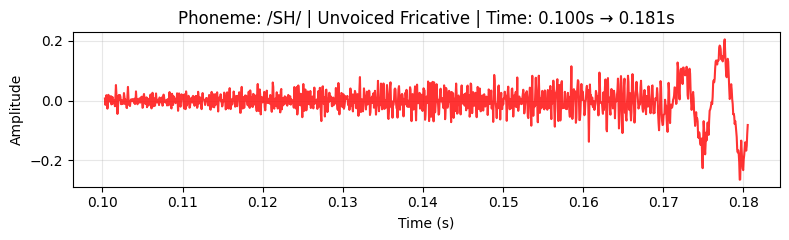

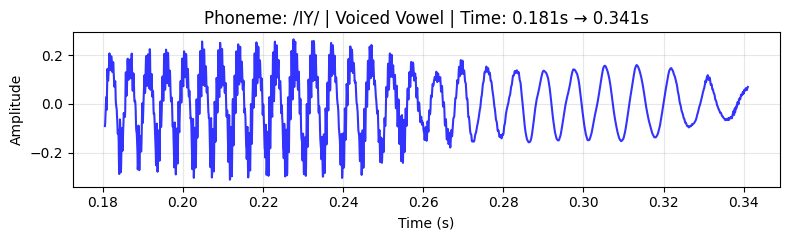

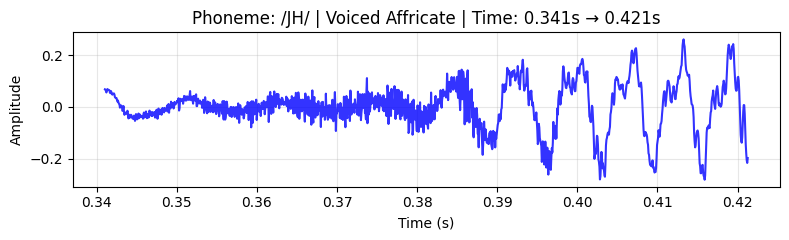

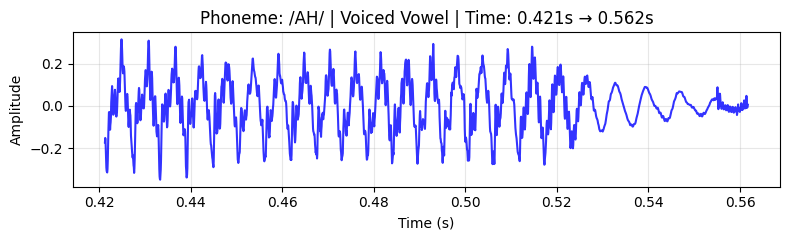

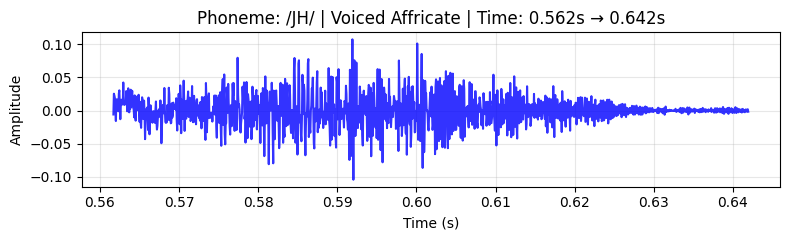

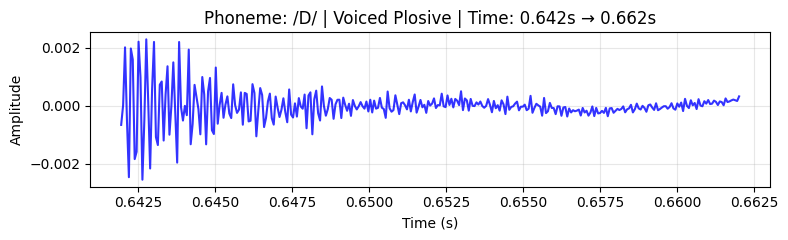

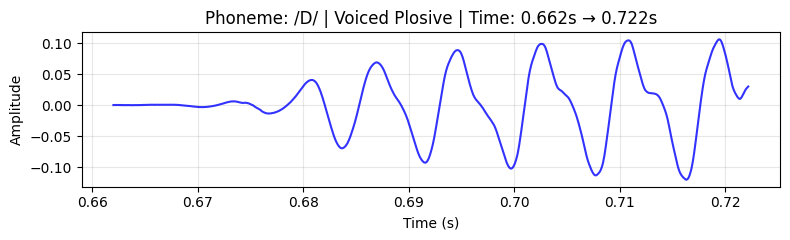

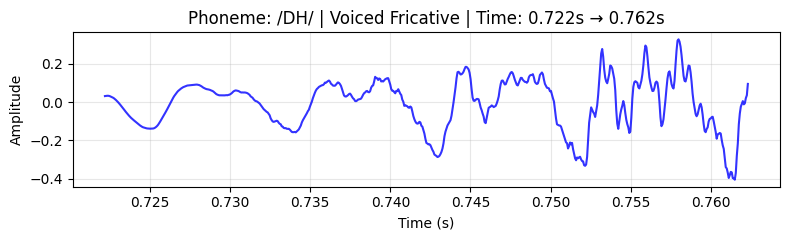

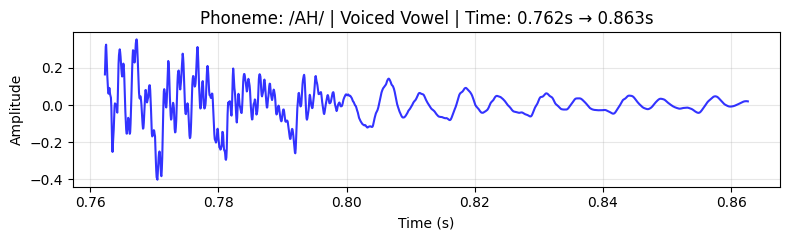

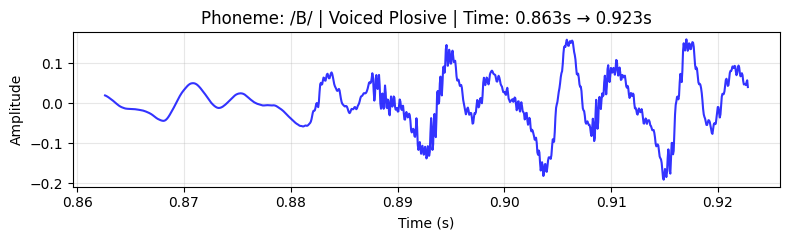

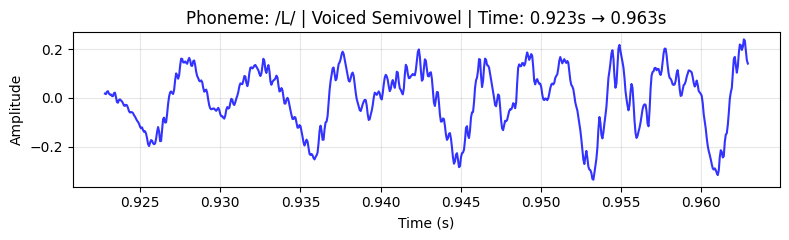

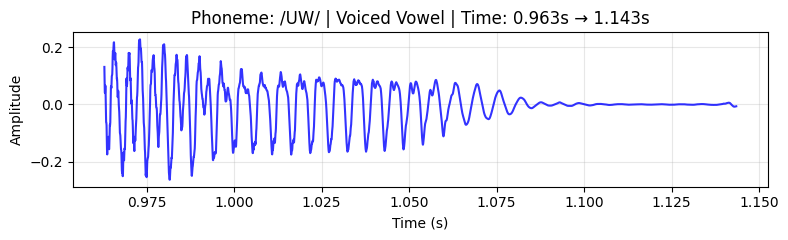

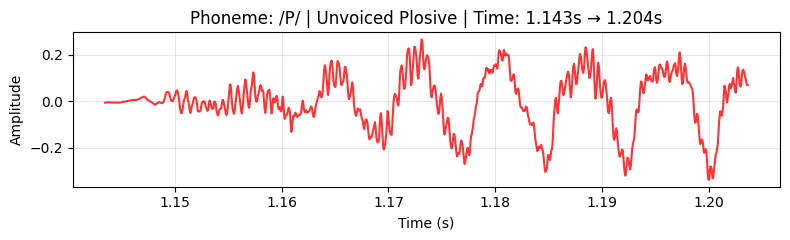

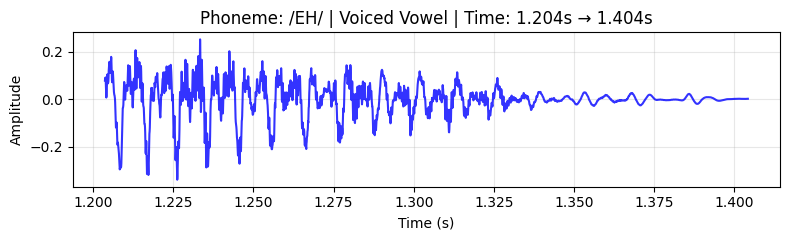

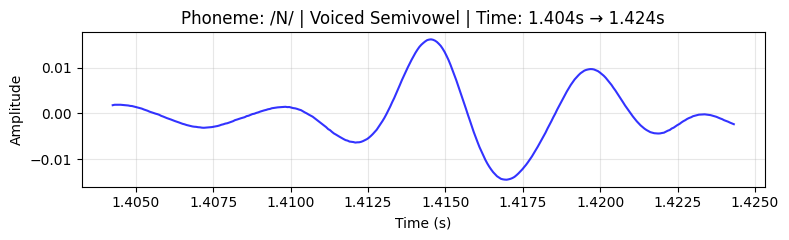

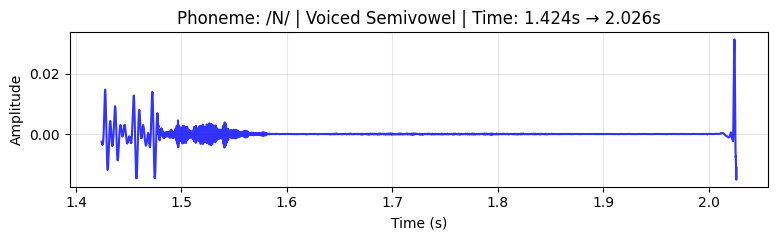

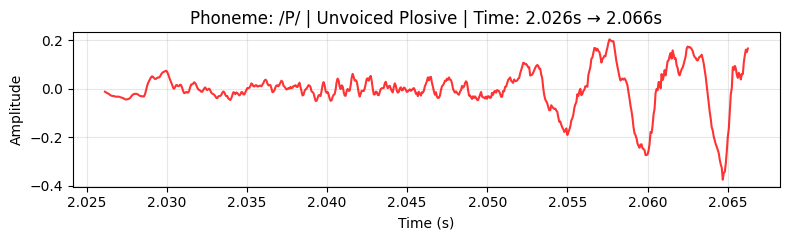

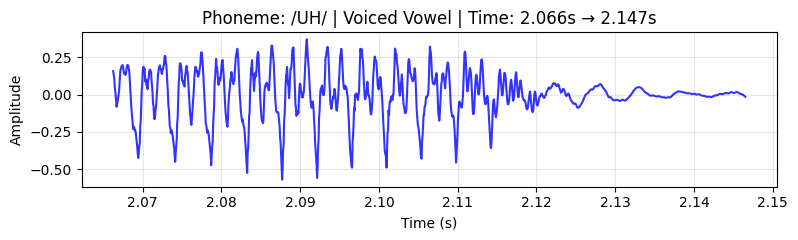

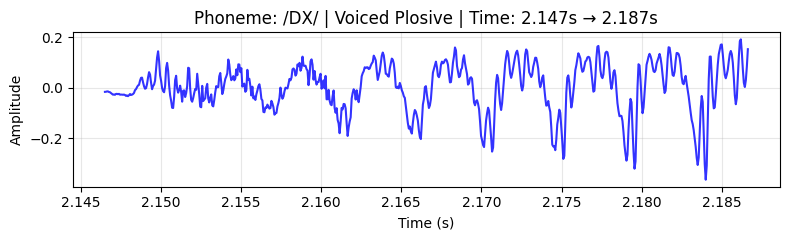

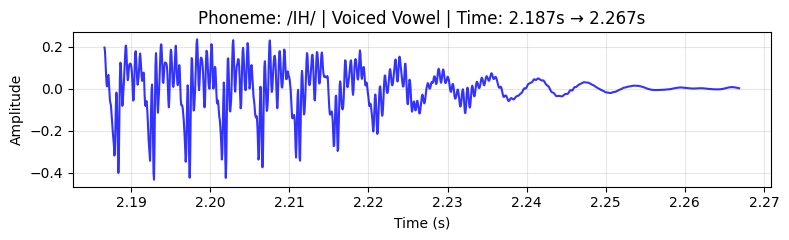

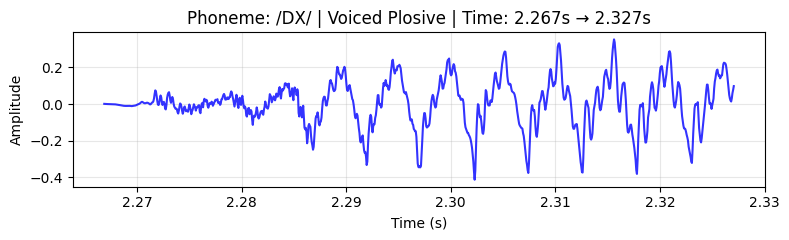

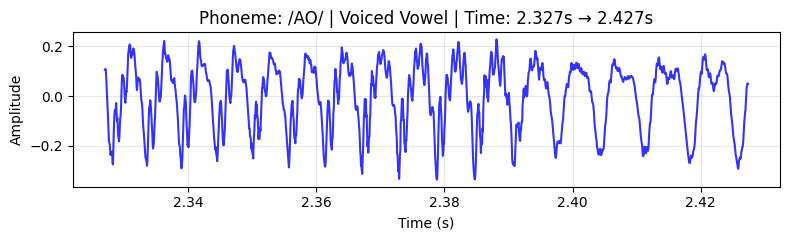

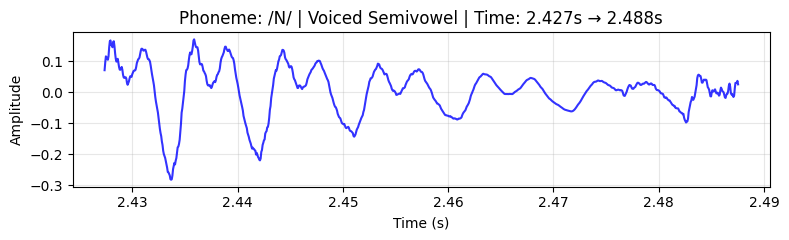

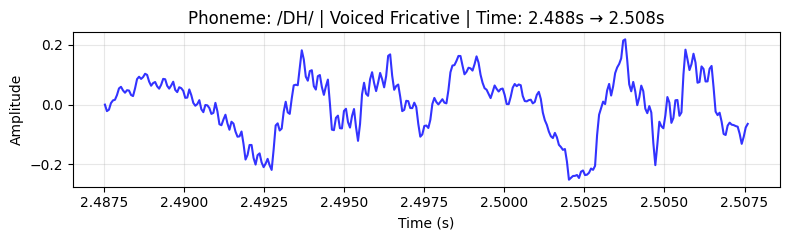

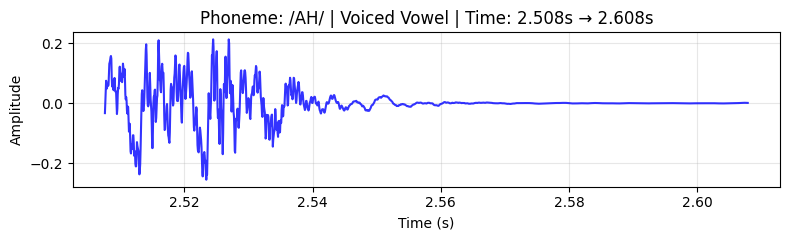

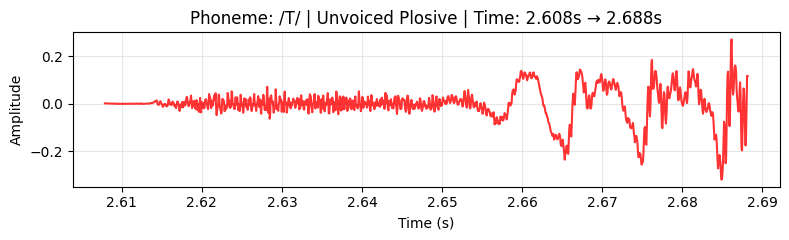

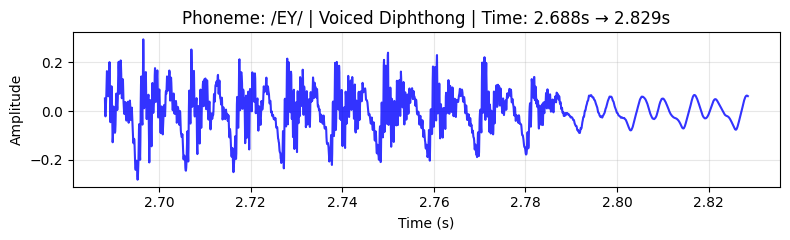

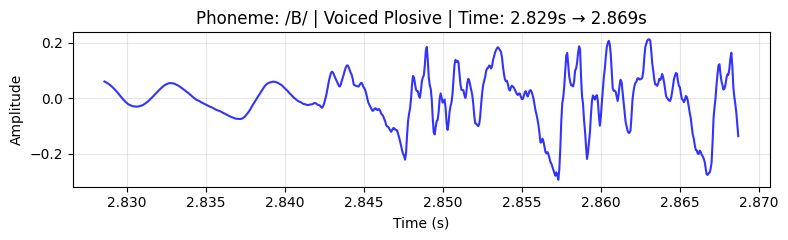

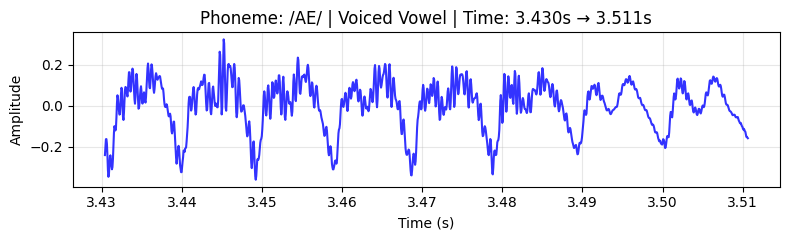

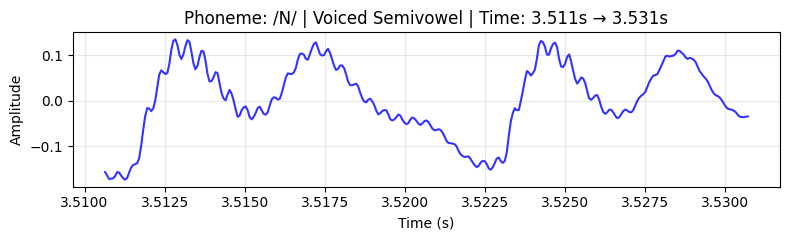

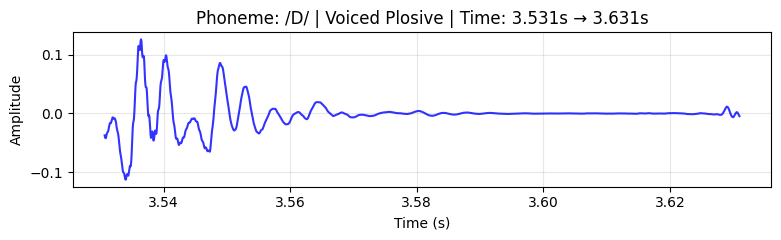

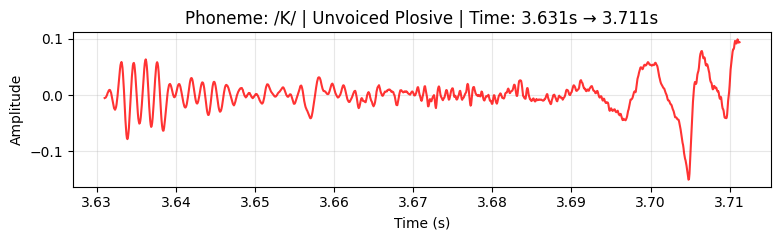

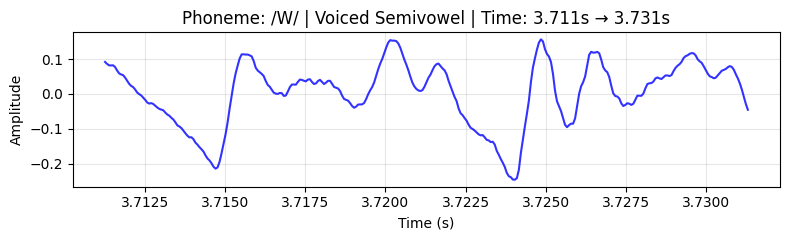

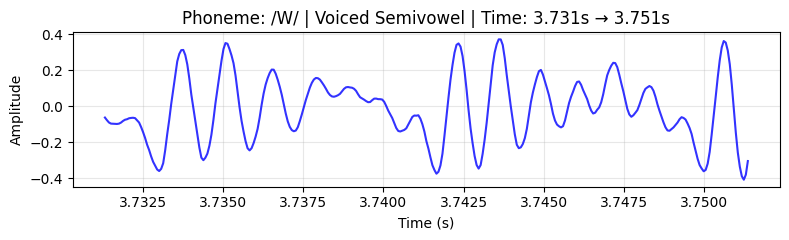

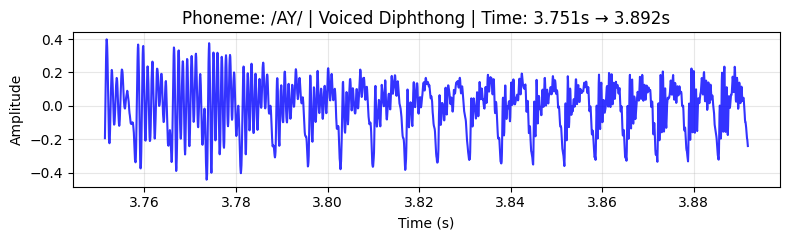

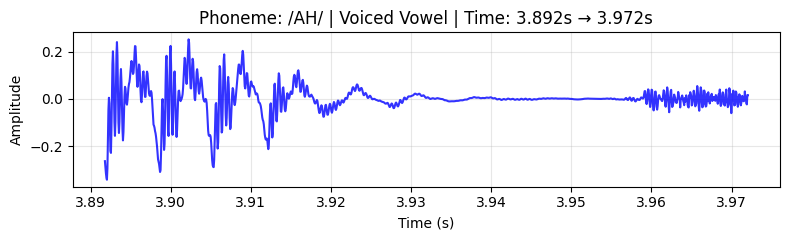

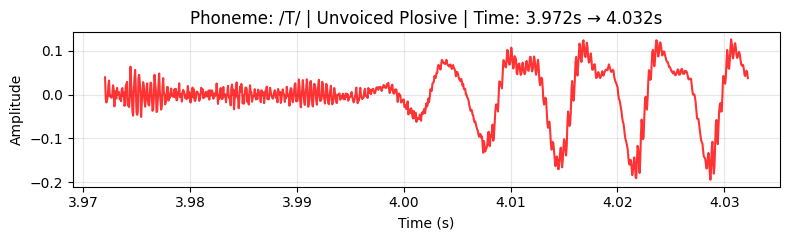

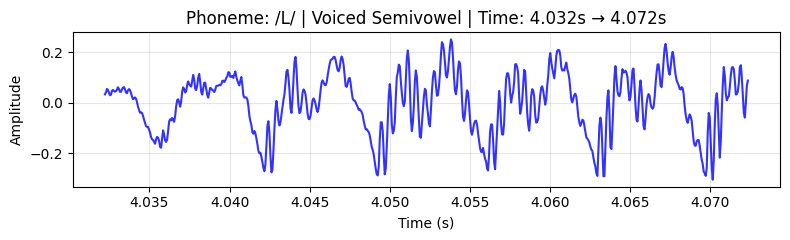

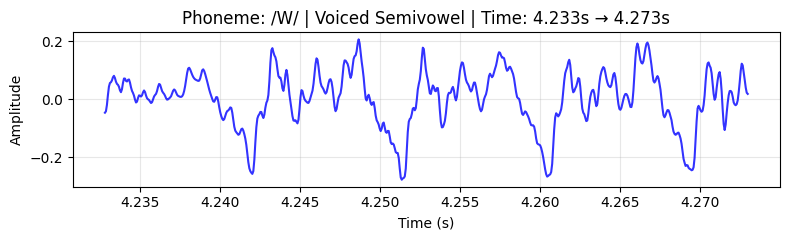

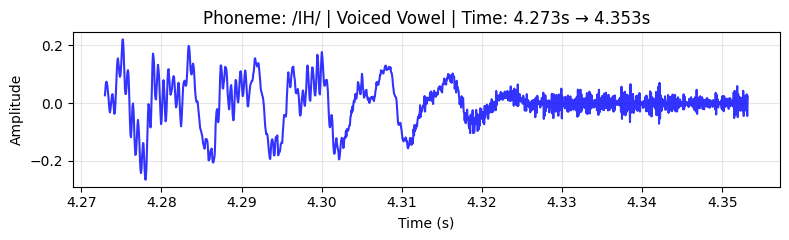

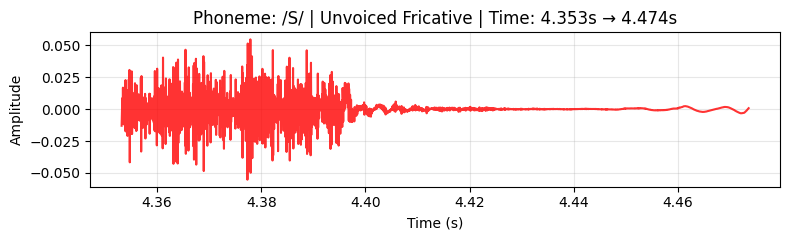

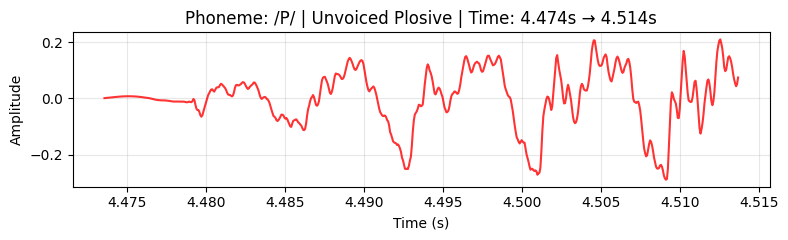

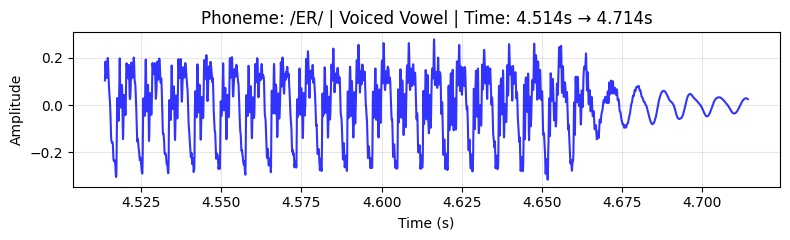

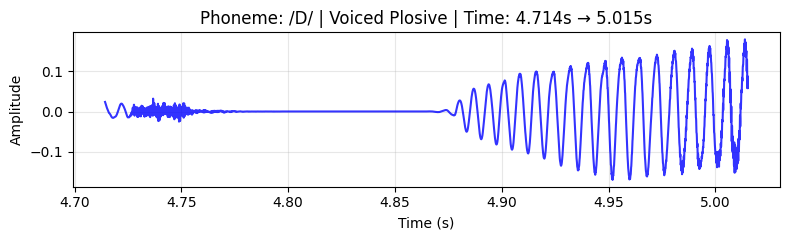

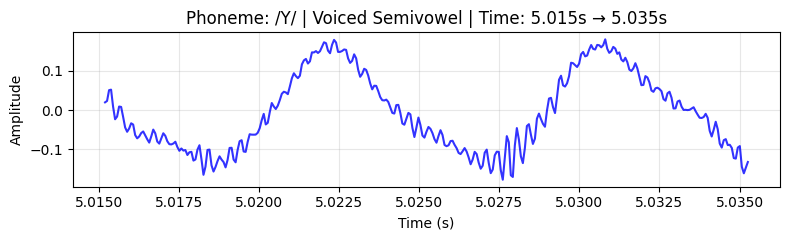

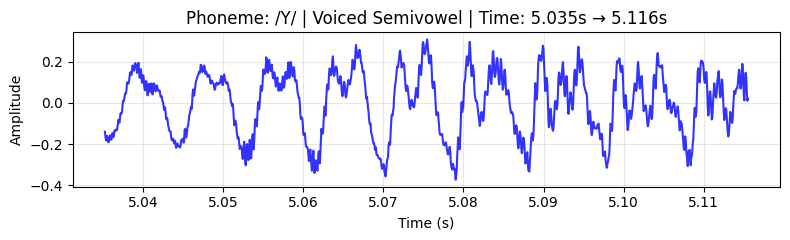

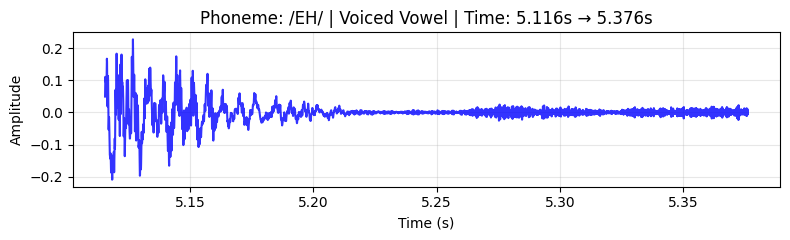

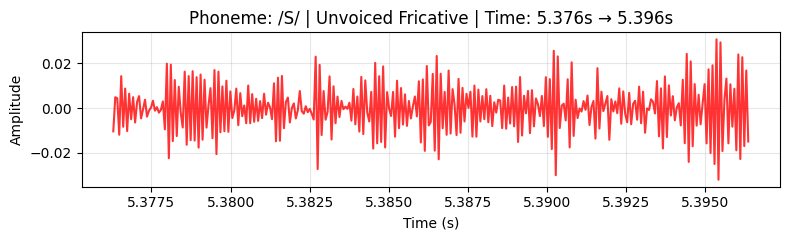

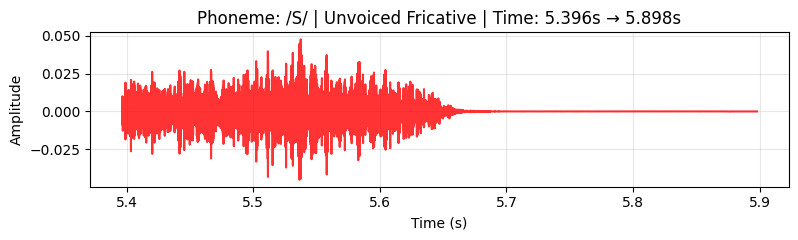

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Loop through each phoneme and create a separate plot
# Now unpacking 5 variables instead of 3
for ph, start, end, voicing, ph_type in phoneme_intervals:

    # Skip unknown or silent tokens if necessary
    if ph_type == 'Unknown':
        continue

    # Convert time (seconds) to sample indices
    start_sample = int(start * target_sr)
    end_sample = int(end * target_sr)

    # Extract the waveform segment for this specific phoneme
    segment_data = waveform_np[start_sample:end_sample]

    # Create a time axis for this specific segment
    time_axis = np.linspace(start, end, len(segment_data))

    # Create a new figure for each phoneme
    plt.figure(figsize=(8, 2.5))

    # Color-code the plots: Blue for Voiced, Red for Unvoiced
    plot_color = 'b' if voicing == 'Voiced' else 'r'
    plt.plot(time_axis, segment_data, color=plot_color, alpha=0.8)

    # Add titles and labels with the new traits
    plt.title(f"Phoneme: /{ph.strip()}/ | {voicing} {ph_type} | Time: {start:.3f}s → {end:.3f}s")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

4. For every phoneme segment:
✓ Identify its phoneme category
(vowel, plosive, fricative, affricate, semivowel, diphthong, or whisper segment).
✓ Label the phoneme accordingly.

In [52]:
print(f"Extracted {len(phoneme_intervals)} phoneme intervals.")

for ph, start, end, voicing, ph_type in phoneme_intervals:
    # Skip any phoneme categorized as 'Unknown'
    if ph_type == 'Unknown':
        continue

    print(f"Phoneme: {ph:>4} | Category: {ph_type:>15} | {start:.3f}s → {end:.3f}s")

Extracted 51 phoneme intervals.
Phoneme:   SH | Category:       Fricative | 0.100s → 0.181s
Phoneme:   IY | Category:           Vowel | 0.181s → 0.341s
Phoneme:   JH | Category:       Affricate | 0.341s → 0.421s
Phoneme:   AH | Category:           Vowel | 0.421s → 0.562s
Phoneme:   JH | Category:       Affricate | 0.562s → 0.642s
Phoneme:    D | Category:         Plosive | 0.642s → 0.662s
Phoneme:    D | Category:         Plosive | 0.662s → 0.722s
Phoneme:   DH | Category:       Fricative | 0.722s → 0.762s
Phoneme:   AH | Category:           Vowel | 0.762s → 0.863s
Phoneme:    B | Category:         Plosive | 0.863s → 0.923s
Phoneme:    L | Category:       Semivowel | 0.923s → 0.963s
Phoneme:   UW | Category:           Vowel | 0.963s → 1.143s
Phoneme:    P | Category:         Plosive | 1.143s → 1.204s
Phoneme:   EH | Category:           Vowel | 1.204s → 1.404s
Phoneme:    N | Category:       Semivowel | 1.404s → 1.424s
Phoneme:    N | Category:       Semivowel | 1.424s → 2.026s
Phoneme:

5.Select and Extract One Voiced and One Unvoiced Segment

In [54]:
voiced_data = None
unvoiced_data = None

# We must unpack all 5 variables here!
for ph, start, end, voicing, ph_type in phoneme_intervals:
    clean_ph = ph.strip()

    # Check the 'voicing' variable directly from Cell 2
    if voiced_data is None and voicing == 'Voiced':
        voiced_data = {"label": clean_ph, "start": start, "end": end}

    if unvoiced_data is None and voicing == 'Unvoiced':
        unvoiced_data = {"label": clean_ph, "start": start, "end": end}

    # Stop searching once we've found one of each
    if voiced_data and unvoiced_data:
        break

# Extract waveform segments
def extract_segment(waveform, start_time, end_time, sr=16000):
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    # Assuming waveform is 1D. Adjust to waveform[0, start_sample:end_sample] if it's 2D.
    return waveform[start_sample:end_sample].numpy()

# Make sure 'target_sr' is defined in your notebook
voiced_segment = extract_segment(waveform, voiced_data['start'], voiced_data['end'])
unvoiced_segment = extract_segment(waveform, unvoiced_data['start'], unvoiced_data['end'])

print(f"Voiced phoneme extracted: /{voiced_data['label']}/")
print(f"Unvoiced phoneme extracted: /{unvoiced_data['label']}/")

Voiced phoneme extracted: /IY/
Unvoiced phoneme extracted: /SH/


6. Compare Waveform Characteristics

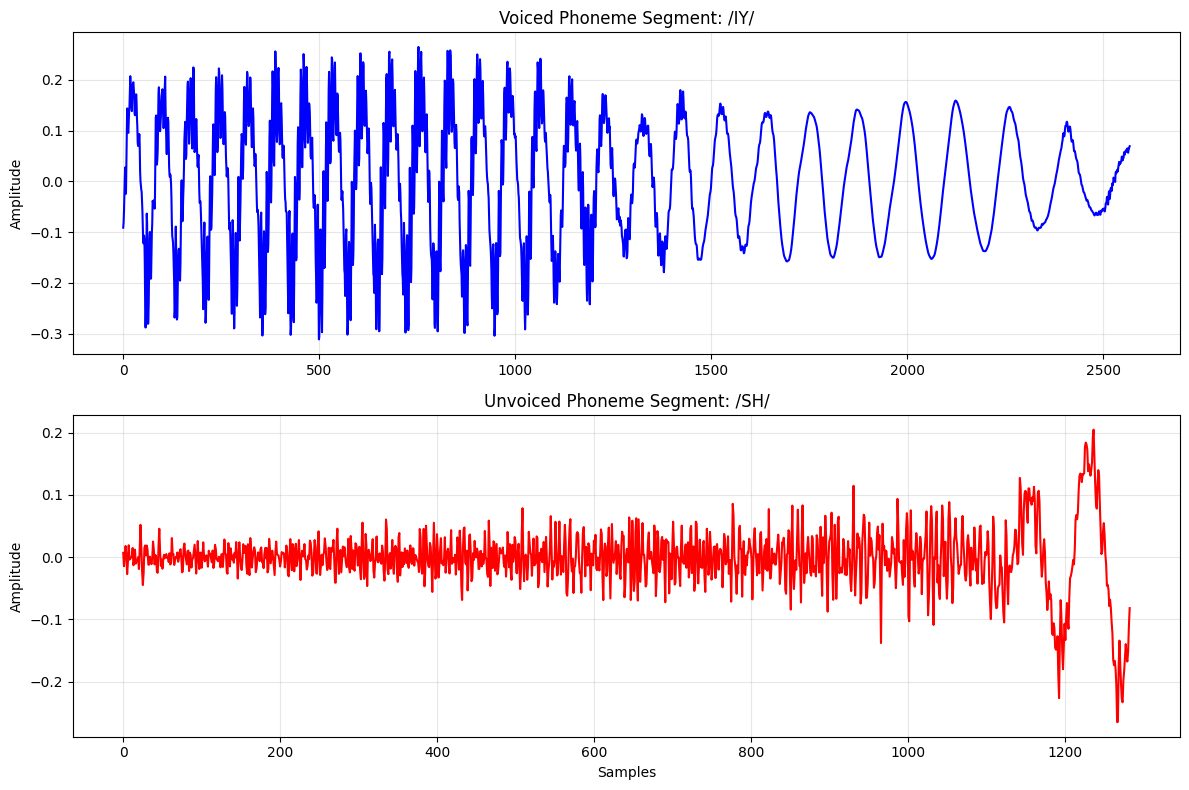


--- Comparative Analysis ---
1. Periodicity:
   - Voiced (/IY/): High periodicity. Clear repeating patterns (glottal pulses) are visible.
   - Unvoiced (/SH/): Aperiodic. The waveform appears random or stochastic.

2. Amplitude Patterns:
   - Voiced: Generally higher amplitude; vowels carry the most energy in the speech signal.
   - Unvoiced: Generally lower amplitude compared to voiced regions.

3. Noise-like Structure:
   - Voiced: Low noise. The structure is harmonic and defined.
   - Unvoiced: High noise. The structure is 'fuzzy,' resembling white or colored noise due to air turbulence.


In [55]:
import matplotlib.pyplot as plt

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# Plot Voiced Segment
ax1.plot(voiced_segment, color='blue')
ax1.set_title(f"Voiced Phoneme Segment: /{voiced_data['label']}/")
ax1.set_ylabel("Amplitude")
ax1.grid(True, alpha=0.3)

# Plot Unvoiced Segment
ax2.plot(unvoiced_segment, color='red')
ax2.set_title(f"Unvoiced Phoneme Segment: /{unvoiced_data['label']}/")
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Samples")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Comparative Analysis for Lab Report ---
print("\n--- Comparative Analysis ---")
print("1. Periodicity:")
print(f"   - Voiced (/{voiced_data['label']}/): High periodicity. Clear repeating patterns (glottal pulses) are visible.")
print(f"   - Unvoiced (/{unvoiced_data['label']}/): Aperiodic. The waveform appears random or stochastic.")

print("\n2. Amplitude Patterns:")
print(f"   - Voiced: Generally higher amplitude; vowels carry the most energy in the speech signal.")
print(f"   - Unvoiced: Generally lower amplitude compared to voiced regions.")

print("\n3. Noise-like Structure:")
print(f"   - Voiced: Low noise. The structure is harmonic and defined.")
print(f"   - Unvoiced: High noise. The structure is 'fuzzy,' resembling white or colored noise due to air turbulence.")

Objective-2: To analyze fricative and approximant speech sounds and infer airflow turbulence
characteristics.

In [56]:
!pip install --quiet transformers torch librosa nltk soundfile
import nltk
nltk.download('cmudict')

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


True

i & ii. Load and Preprocess the Recorded Speech Signal

In [62]:
import librosa
import torch

# 1. Load audio using librosa (Logic from Cell 9 of reference)
audio_path = "objective02_n.wav"
waveform_np, sample_rate = librosa.load(audio_path, sr=None, mono=True)

# 2. Resample to 16kHz as required for Wav2Vec2
target_sr = 16000
waveform_np = librosa.resample(waveform_np, orig_sr=sample_rate, target_sr=target_sr)
waveform = torch.tensor(waveform_np)

print(f"Audio loaded. Waveform shape: {waveform.shape}")
print(f"Sample rate: {target_sr}")
display(Audio(data=waveform_np, rate=target_sr))

Audio loaded. Waveform shape: torch.Size([51642])
Sample rate: 16000


iii & iv. Automatic Segmentation and Isolation of Targets

In [58]:
# Reuse the phonetic model from Objective 1
processor_ph = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")
model_ph = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")

# Speech to Phonemes
inputs = processor_ph(waveform_np, sampling_rate=target_sr, return_tensors="pt", padding=True)
with torch.no_grad():
    logits = model_ph(inputs.input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)

# Get exact time per frame
num_frames = logits.shape[1]
audio_duration = waveform.shape[0] / target_sr
time_per_frame = audio_duration / num_frames

# Extract phonemes and start times
tokens = predicted_ids[0].numpy()
intervals = []

for i, token in enumerate(tokens):
    if token != processor_ph.tokenizer.pad_token_id:
        phoneme_ipa = processor_ph.decode([token]).strip()
        if phoneme_ipa:
            arpa_ph = ipa_to_arpa.get(phoneme_ipa, phoneme_ipa) # using dictionary from Obj 1
            start_time = i * time_per_frame
            intervals.append({"phoneme": arpa_ph, "start": start_time})

# Calculate intervals and isolate Fricatives and Approximants
targets = []
for idx, target_p in enumerate(intervals):
    ph = target_p['phoneme'].strip()
    start = target_p['start']
    end = intervals[idx+1]['start'] if idx+1 < len(intervals) else audio_duration

    # Isolate targets: Fricatives (|s|, |ʃ/SH|, |z|) and Approximants (/j/ or Y)
    if ph in ['S', 'SH', 'Z']:
        targets.append({'label': ph, 'type': 'Fricative', 'start': start, 'end': end})
    elif ph in ['Y', 'J']: # Y represents the /j/ approximant in "you"
        targets.append({'label': ph, 'type': 'Approximant', 'start': start, 'end': end})

print(f"Isolated {len(targets)} precise segments for visualization.")
for t in targets:
    print(f"Found {t['type']} /{t['label']}/ from {t['start']:.3f}s to {t['end']:.3f}s")

Loading weights:   0%|          | 0/424 [00:00<?, ?it/s]

Isolated 4 precise segments for visualization.
Found Fricative /SH/ from 0.922s to 1.002s
Found Fricative /S/ from 1.223s to 1.343s
Found Fricative /Z/ from 1.504s to 1.604s
Found Approximant /Y/ from 1.604s to 1.644s


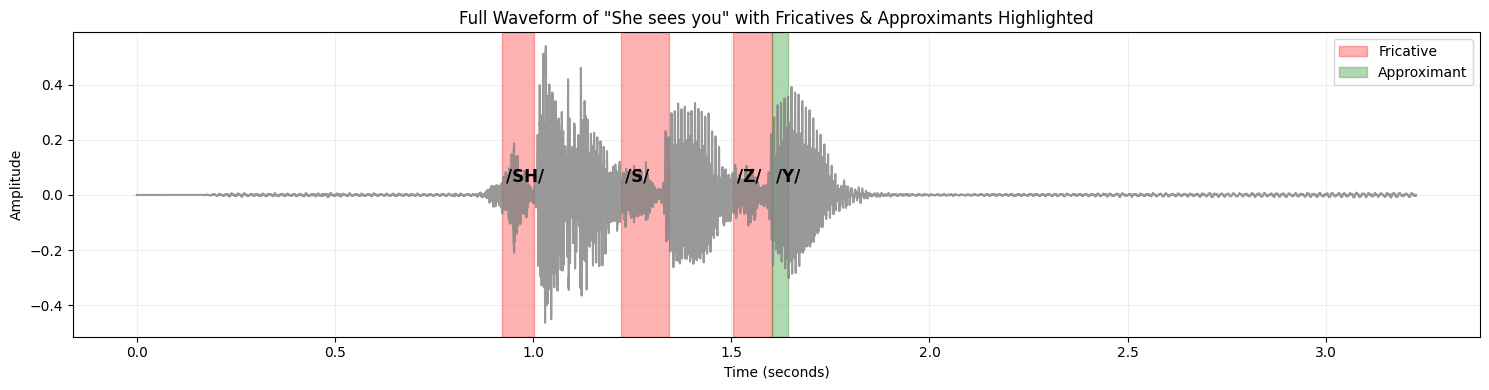

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Create a time axis for the entire audio clip
time_axis_full = np.linspace(0, len(waveform_np) / target_sr, len(waveform_np))

plt.figure(figsize=(15, 4))
# Plot the full, original waveform in a neutral color
plt.plot(time_axis_full, waveform_np, color='gray', alpha=0.8)

# Define colors for our highlights
highlight_colors = {'Fricative': 'red', 'Approximant': 'green'}

# Loop through the targets and add colored highlighted blocks (axvspan)
for t in targets:
    plt.axvspan(t['start'], t['end'], color=highlight_colors[t['type']], alpha=0.3, label=t['type'])
    # Add text labels slightly above the center line
    plt.text(t['start'] + 0.01, 0.05, f"/{t['label']}/", fontsize=12, color='black', fontweight='bold')

# Fix the legend so it doesn't repeat 'Fricative' multiple times
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper right')

plt.title('Full Waveform of "She sees you" with Fricatives & Approximants Highlighted')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

v. Plot the Waveforms of Extracted Segments

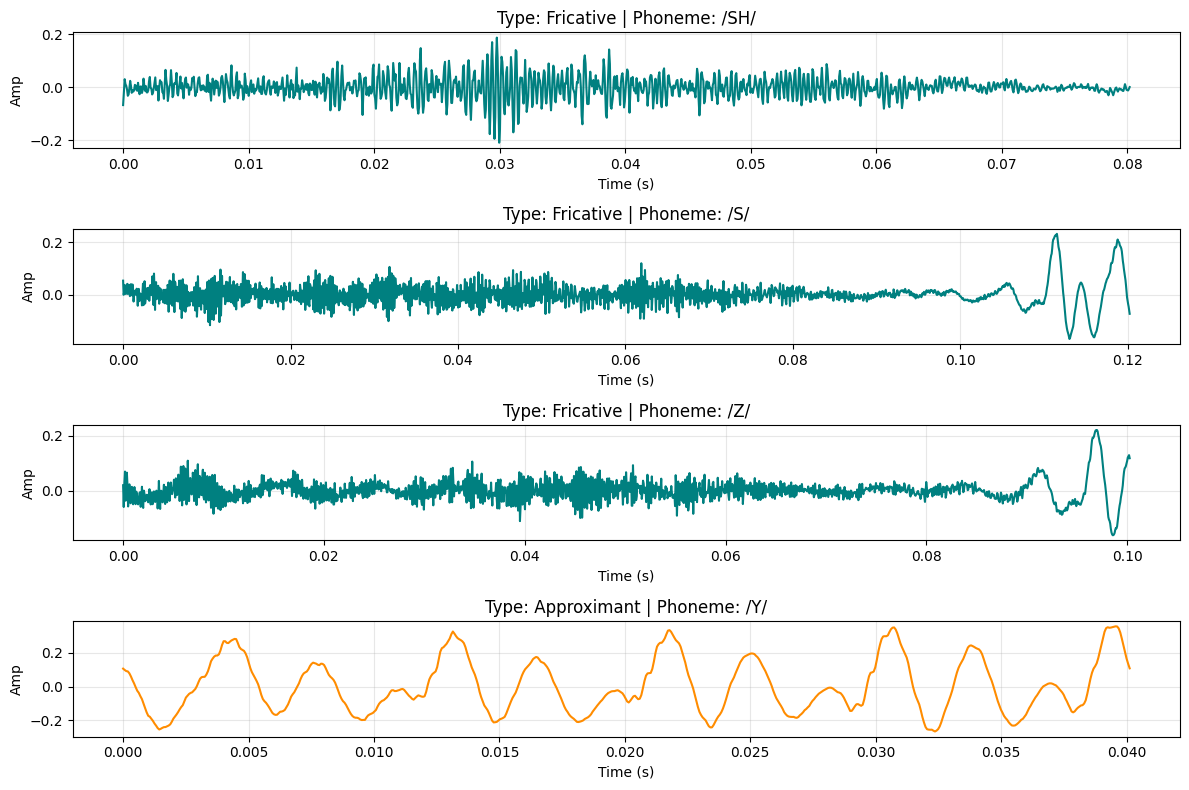

In [60]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

for i, seg in enumerate(targets):
    start_sample = int(seg['start'] * target_sr)
    end_sample = int(seg['end'] * target_sr)
    segment_data = waveform_np[start_sample:end_sample]

    # Time axis for plotting
    time_axis = np.linspace(0, len(segment_data) / target_sr, len(segment_data))

    plt.subplot(len(targets), 1, i + 1)
    plt.plot(time_axis, segment_data, color='teal' if seg['type'] == 'Fricative' else 'darkorange')
    plt.title(f"Type: {seg['type']} | Phoneme: /{seg['label']}/")
    plt.xlabel("Time (s)")
    plt.ylabel("Amp")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Theoretical Analysis (vi, vii, viii)

**vi. Qualitative Differences in Waveform:**
* **Fricatives (/s/, /ʃ/, /z/):** The waveforms display high irregularity, lack clear periodic patterns, and contain rapid, noise-like amplitude fluctuations.
* **Approximants (/j/):** The waveform is smooth, exhibits continuous amplitude variations, and shows clear, quasi-periodic structures (similar to vowels).

**vii. Airflow Turbulence Inference:**
* Based on the noisy and aperiodic waveform, the airflow for **fricatives** is **turbulent**, which is associated with a **higher effective Reynolds number**.
* Based on the smooth and periodic waveform, the airflow for **approximants** is **smooth/laminar**, which is associated with a **lower effective Reynolds number**.

**viii. Articulatory Constriction Differences:**
* **Fricatives:** The turbulent waveform is caused by a tight articulatory constriction in the vocal tract. Air is forced through this narrow gap at high velocity, creating a jet that becomes unstable and breaks into turbulence (noise).
* **Approximants:** The smooth waveform is a result of a wider articulatory constriction. The vocal tract acts like a resonant tube, allowing the airflow to remain laminar and preserving the periodic vibration from the vocal folds.